## PLOT: map distribution of worship centres and foreign inhabitants in Catalonia (by municipalities)

To run this code you need to have the personalised file "foreign_faith_distribution.json", a geodataframe generated by the "Extract_info_datasets.ipynb" notebook.

Plot of spatial distributions in the Catalonia map. We use the spatial information of the Geodataframe.

We essentially plot two kind of maps:

- Diversity heatmap calculated from the Shannon-Wiener index
- Distribution of worship centres per religion related with the foreign population density

In [79]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import PowerNorm
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np

LOAD THE FILE WITH ALL THE VARIABLES

In [80]:
foreign_faith_distribution = gpd.read_file("foreign_faith_distribution.json") 

## FINAL MAP 1: HEATMAP FOR THE SHANNON-WIENER INDEX CORRELATION

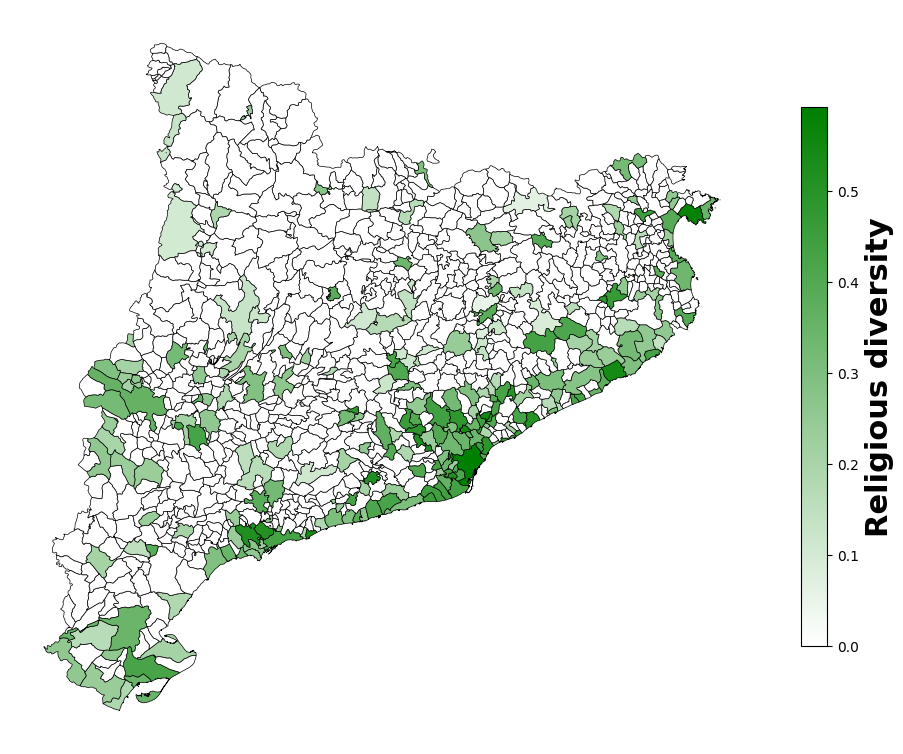

In [81]:
# Column to be plotted: Normalized Shannon-Wiener Index
variable_name = 'Normalized_Shaw_Idx'

# Colormap: white to green
white_to_green = LinearSegmentedColormap.from_list('WhiteToGreen', ['white', 'green'])

# Ensure geometries are valid
foreign_faith_distribution = foreign_faith_distribution.set_geometry("geometry")
foreign_faith_distribution = foreign_faith_distribution[foreign_faith_distribution.is_valid]

# Ensure the CRS is valid
if foreign_faith_distribution.crs is None:
    foreign_faith_distribution = foreign_faith_distribution.set_crs("EPSG:4326", allow_override=True)

# Reproject to Web Mercator (EPSG:3857) for compatibility with visualization tools
foreign_faith_distribution = foreign_faith_distribution.to_crs("EPSG:3857")

# Replace NaN values with -1 (optional)
foreign_faith_distribution[variable_name] = foreign_faith_distribution[variable_name].replace({np.nan: -1})

# Normalize values for color scaling
norm = mcolors.Normalize(
    vmin=foreign_faith_distribution[variable_name].replace({-1: np.nan}).min(),
    vmax=foreign_faith_distribution[variable_name].replace({-1: np.nan}).max()
)

# Create the plot
shannon_index_fig, ax = plt.subplots(1, 1, figsize=(12, 10))

foreign_faith_distribution.plot(
    column=variable_name,
    cmap=white_to_green,  # Use the custom colormap
    norm=norm,
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    legend_kwds={
        'label': "Shannon-Wiener Index (Normalized)",  # Etiqueta del legend
        'shrink': 0.7  # Reduce el tamaño de la colorbar (70% de su altura original)
    },
    missing_kwds={
        "color": "lightgrey",  # Color for areas with no data
        "label": "No Data"     # Label for missing data in the legend
    },
    ax=ax
)

# Locate and modify the legend
cbar = ax.get_figure().get_axes()[-1]  # Colorbar is usually the last axis added
cbar.set_ylabel("Religious diversity", weight='bold', fontsize=22)  # Set bold font and size

# Remove axes for a cleaner map visualization
ax.set_axis_off()

# Display the plot
plt.show()


## FINAL MAP 2: CATHOLIC CENTRES 

We can do some additional changes: legend, layout, ...

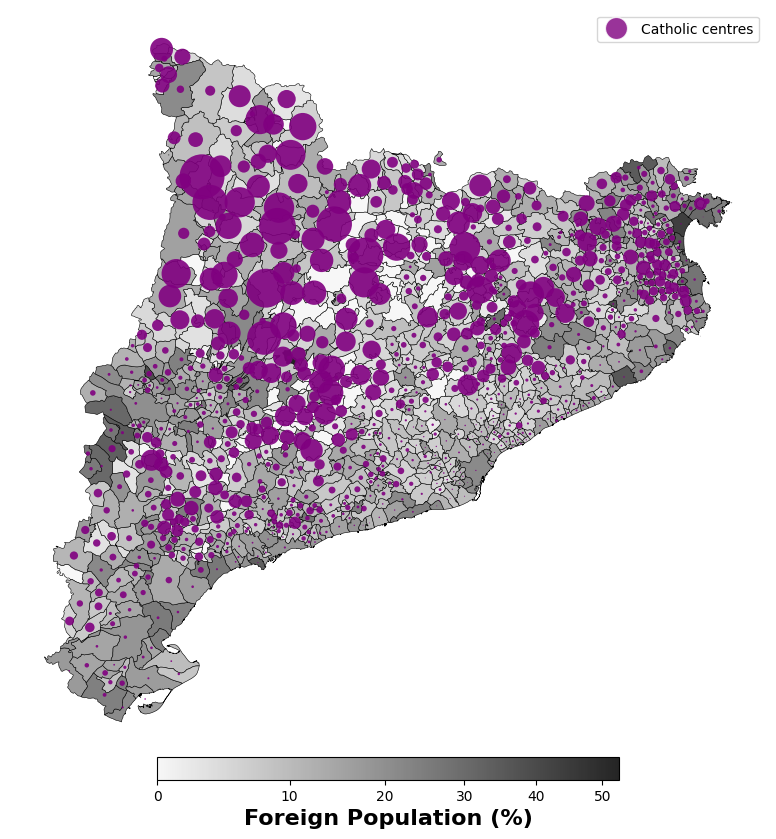

In [82]:
## RELIGION
religion_point = 'Normalised_catholic_2021'
variable_name = 'Población extranjera. % sobre (1)'  # Nombre de la columna para el mapa principal

# Asegurar que las geometrías son válidas
foreign_faith_distribution = foreign_faith_distribution.set_geometry("geometry")
foreign_faith_distribution = foreign_faith_distribution[foreign_faith_distribution.is_valid]

# Asegurar que hay un CRS válido
if foreign_faith_distribution.crs is None:
    foreign_faith_distribution = foreign_faith_distribution.set_crs("EPSG:4326", allow_override=True)

# Reproyectar a un CRS adecuado para visualización
foreign_faith_distribution = foreign_faith_distribution.to_crs("EPSG:3857")

# Reemplazar NaN en la columna del mapa principal con un valor adecuado
foreign_faith_distribution[variable_name] = foreign_faith_distribution[variable_name].replace({np.nan: -1})

# Crear colormap
# Crear un colormap monocromático de escala de grises personalizada
custom_greys = LinearSegmentedColormap.from_list("CustomGreys", ["#f7f7f7", "#252525"])
cmap = custom_greys
# Ajusta gamma (más bajo, más intenso)
norm = PowerNorm(gamma=0.7, vmin=foreign_faith_distribution[variable_name].replace({-1: np.nan}).min(), 
                 vmax=foreign_faith_distribution[variable_name].replace({-1: np.nan}).max())  

# Crear la figura y el eje
faith_distribution_fig1, ax = plt.subplots(1, 1, figsize=(12, 10))

# Graficar el shapefile con el colormap sin leyenda automática
foreign_faith_distribution.plot(
    column=variable_name,
    cmap=cmap,
    norm=norm,
    linewidth=0.4,
    edgecolor='black',
    legend=False,
    missing_kwds={
        "color": "lightgrey",  # Color para áreas sin datos
        "label": "No Data"     # Etiqueta en la leyenda
    },
    ax=ax
)

# Crear la barra de color (colorbar) y asociarla con el eje 'ax' en horizontal
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = foreign_people_distribution_fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.03, pad=0.001)
cbar.set_label('Foreign Population (%)', fontsize=16, fontweight='bold')

# Ajustar el espacio para que la barra de color no se solape con el gráfico
foreign_people_distribution_fig.subplots_adjust(bottom=0.15)

# Quitar los ejes
ax.set_axis_off()

# Filtrar datos válidos para la columna de puntos
foreign_faith_distribution_valid = foreign_faith_distribution[
    foreign_faith_distribution[religion_point].notna() & 
    (foreign_faith_distribution[religion_point] > 0)
]

# Verificar que hay datos válidos para graficar puntos
if not foreign_faith_distribution_valid.empty:
    # Obtener los centroides de los municipios válidos
    foreign_faith_distribution_valid = foreign_faith_distribution_valid[
        foreign_faith_distribution_valid.geometry.is_valid
    ]
    centroides = foreign_faith_distribution_valid.geometry.centroid

    # Escalar el tamaño de los puntos proporcional al valor en 'religion_point'
    sizes = foreign_faith_distribution_valid[religion_point] * 6000
    sizes = sizes.fillna(0.1)  # Reemplazar NaN con un tamaño mínimo
    sizes = sizes.clip(lower=0.1)  # Asegurar que los tamaños sean mayores a 0

    # Graficar los puntos con tamaños ajustados
    ax.scatter(
        centroides.x,
        centroides.y,
        s=sizes,
        color='purple',
        alpha=0.9,
        edgecolors='none',
    )
# Agregar una leyenda para los puntos con el mismo tamaño en la leyenda
from matplotlib.legend_handler import HandlerTuple

# Crear un tamaño uniforme para los puntos en la leyenda
legend_points = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=16, alpha=0.8, label='Catholic centres'),
]

ax.legend(handles=legend_points)

# Mostrar el mapa
plt.show()
faith_distribution_fig1.savefig("faith_distribution1.png", format="jpg",dpi=300,bbox_inches="tight")

## FINAL MAP 3: NON-CATHOLIC CENTRES (scaling needed)

We apply a scale in order to be able to compare non-catholic and catholic centres (last one's are much higher in magnitude)

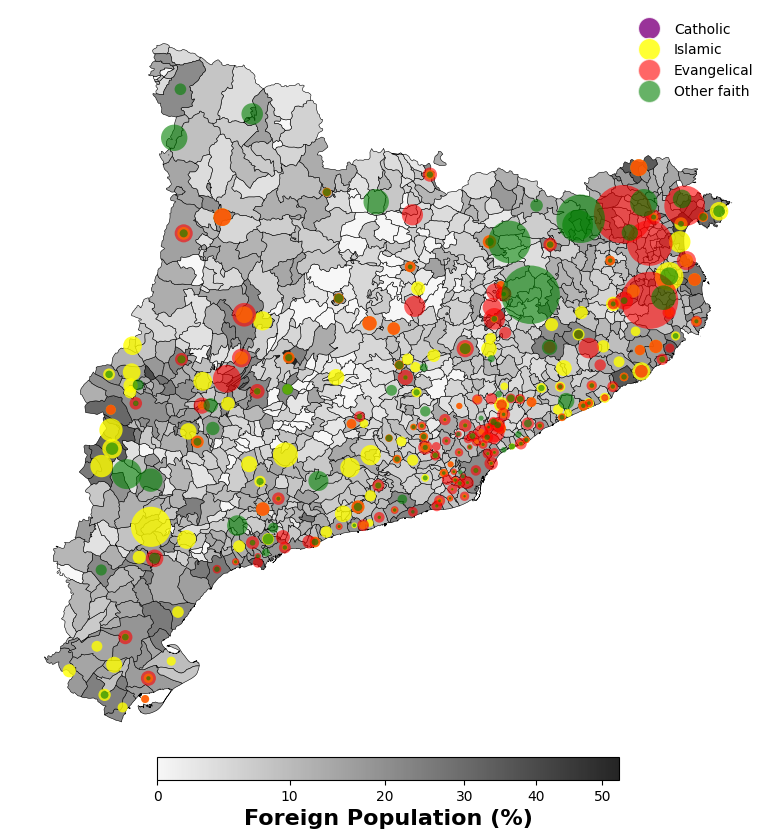

In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Variables de entrada
religion_point = 'Normalised_islam_2021'
religion_point2 = 'Normalised_evangelical_2021'
religion_point3 = 'Normalised_others_2021'
variable_name = 'Población extranjera. % sobre (1)'  # Nombre de la columna para el mapa principal

# Asegurar que las geometrías son válidas
foreign_faith_distribution = foreign_faith_distribution.set_geometry("geometry")
foreign_faith_distribution = foreign_faith_distribution[foreign_faith_distribution.is_valid]

# Asegurar que hay un CRS válido
if foreign_faith_distribution.crs is None:
    foreign_faith_distribution = foreign_faith_distribution.set_crs("EPSG:4326", allow_override=True)

# Reproyectar a un CRS adecuado para visualización
foreign_faith_distribution = foreign_faith_distribution.to_crs("EPSG:3857")

# Reemplazar NaN en la columna del mapa principal con un valor adecuado
foreign_faith_distribution[variable_name] = foreign_faith_distribution[variable_name].replace({np.nan: -1})

# Crear colormap
# Crear un colormap monocromático de escala de grises personalizada
custom_greys = LinearSegmentedColormap.from_list("CustomGreys", ["#f7f7f7", "#252525"])
cmap = custom_greys

# Ajusta gamma (más bajo, más intenso)
norm = PowerNorm(gamma=0.7, vmin=foreign_faith_distribution[variable_name].replace({-1: np.nan}).min(), 
                 vmax=foreign_faith_distribution[variable_name].replace({-1: np.nan}).max())  

# Crear la figura y el eje
faith_distribution_fig2, ax = plt.subplots(1, 1, figsize=(12, 10))

# Graficar el shapefile con el colormap sin leyenda automática
foreign_faith_distribution.plot(
    column=variable_name,
    cmap=cmap,
    norm=norm,
    linewidth=0.4,
    edgecolor='black',
    legend=False,
    missing_kwds={
        "color": "lightgrey",  # Color para áreas sin datos
        "label": "No Data"     # Etiqueta en la leyenda
    },
    ax=ax
)

# Crear la barra de color (colorbar) y asociarla con el eje 'ax' en horizontal
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = foreign_people_distribution_fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.03, pad=0.001)
cbar.set_label('Foreign Population (%)', fontsize=16, fontweight='bold')

# Ajustar el espacio para que la barra de color no se solape con el gráfico
foreign_people_distribution_fig.subplots_adjust(bottom=0.15)

# Quitar los ejes
ax.set_axis_off()

# Filtrar datos válidos para la columna de puntos (Islam)
foreign_faith_distribution_valid = foreign_faith_distribution[
    foreign_faith_distribution[religion_point].notna() & 
    (foreign_faith_distribution[religion_point] > 0)
]

# Verificar que hay datos válidos para graficar puntos
if not foreign_faith_distribution_valid.empty:
    # Obtener los centroides de los municipios válidos
    foreign_faith_distribution_valid = foreign_faith_distribution_valid[
        foreign_faith_distribution_valid.geometry.is_valid
    ]
    centroides = foreign_faith_distribution_valid.geometry.centroid

    # Escalar el tamaño de los puntos proporcional al valor en 'religion_point'
    sizes = foreign_faith_distribution_valid[religion_point] * 500000
    sizes = sizes.fillna(0.1)  # Reemplazar NaN con un tamaño mínimo
    sizes = sizes.clip(lower=0.1)  # Asegurar que los tamaños sean mayores a 0

    # Graficar los puntos con tamaños ajustados
    ax.scatter(
        centroides.x,
        centroides.y,
        s=sizes,
        color='yellow',
        alpha=0.8,
        edgecolors='none',
        label=f'Islam centres'
    )

# Filtrar datos válidos para la segunda columna de puntos (evangelican)
foreign_faith_distribution_valid2 = foreign_faith_distribution[
    foreign_faith_distribution[religion_point2].notna() & 
    (foreign_faith_distribution[religion_point2] > 0)
]

# Verificar que hay datos válidos para graficar los nuevos puntos
if not foreign_faith_distribution_valid2.empty:
    # Obtener los centroides de los municipios válidos
    foreign_faith_distribution_valid2 = foreign_faith_distribution_valid2[
        foreign_faith_distribution_valid2.geometry.is_valid
    ]
    centroides2 = foreign_faith_distribution_valid2.geometry.centroid

    # Escalar el tamaño de los puntos proporcional al valor en 'religion_point2'
    sizes2 = foreign_faith_distribution_valid2[religion_point2] * 500000
    sizes2 = sizes2.fillna(0.1)  # Reemplazar NaN con un tamaño mínimo
    sizes2 = sizes2.clip(lower=0.1)  # Asegurar que los tamaños sean mayores a 0

    # Graficar los nuevos puntos con tamaños ajustados
    ax.scatter(
        centroides2.x,
        centroides2.y,
        s=sizes2,
        color='red',  # Color diferente para distinguirlo de los primeros puntos
        alpha=0.6,
        edgecolors='none',
        label=f'Evangelical centres'
    )

# Filtrar datos válidos para la segunda columna de puntos (others)
foreign_faith_distribution_valid3 = foreign_faith_distribution[
    foreign_faith_distribution[religion_point3].notna() & 
    (foreign_faith_distribution[religion_point3] > 0)
]

# Verificar que hay datos válidos para graficar los nuevos puntos
if not foreign_faith_distribution_valid3.empty:
    # Obtener los centroides de los municipios válidos
    foreign_faith_distribution_valid3 = foreign_faith_distribution_valid3[
        foreign_faith_distribution_valid3.geometry.is_valid
    ]
    centroides3 = foreign_faith_distribution_valid3.geometry.centroid

    # Escalar el tamaño de los puntos proporcional al valor en 'religion_point3'
    sizes3 = foreign_faith_distribution_valid3[religion_point3] * 200000
    sizes3 = sizes3.fillna(0.1)  # Reemplazar NaN con un tamaño mínimo
    sizes3 = sizes3.clip(lower=0.1)  # Asegurar que los tamaños sean mayores a 0

    # Graficar los nuevos puntos con tamaños ajustados
    ax.scatter(
        centroides3.x,
        centroides3.y,
        s=sizes3,
        color='green',  # Color diferente para distinguirlo de los primeros puntos
        alpha=0.6,
        edgecolors='none',
        label=f'Other non-catholic centres'
    )

# Agregar una leyenda para los puntos con el mismo tamaño en la leyenda
from matplotlib.legend_handler import HandlerTuple

# Crear un tamaño uniforme para los puntos en la leyenda
legend_points = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=16, alpha=0.8, label='Catholic'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=16, alpha=0.8, label='Islamic'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=16, alpha=0.6, label='Evangelical'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=16, alpha=0.6, label='Other faith')
]

ax.legend(handles=legend_points, frameon=False)

# Mostrar el mapa
plt.show()
faith_distribution_fig2.savefig("faith_distribution2.png", format="jpg",dpi=300,bbox_inches="tight")

## TREEMAP PLOT: COMPARISON OF THE TOTAL Nº OF CENTRES PER RELIGION

TO VISUALIZE WHY IT'S IMPORTANT TO SCALE THE DIFFERENT RELIGIONS DIFFERENTLY

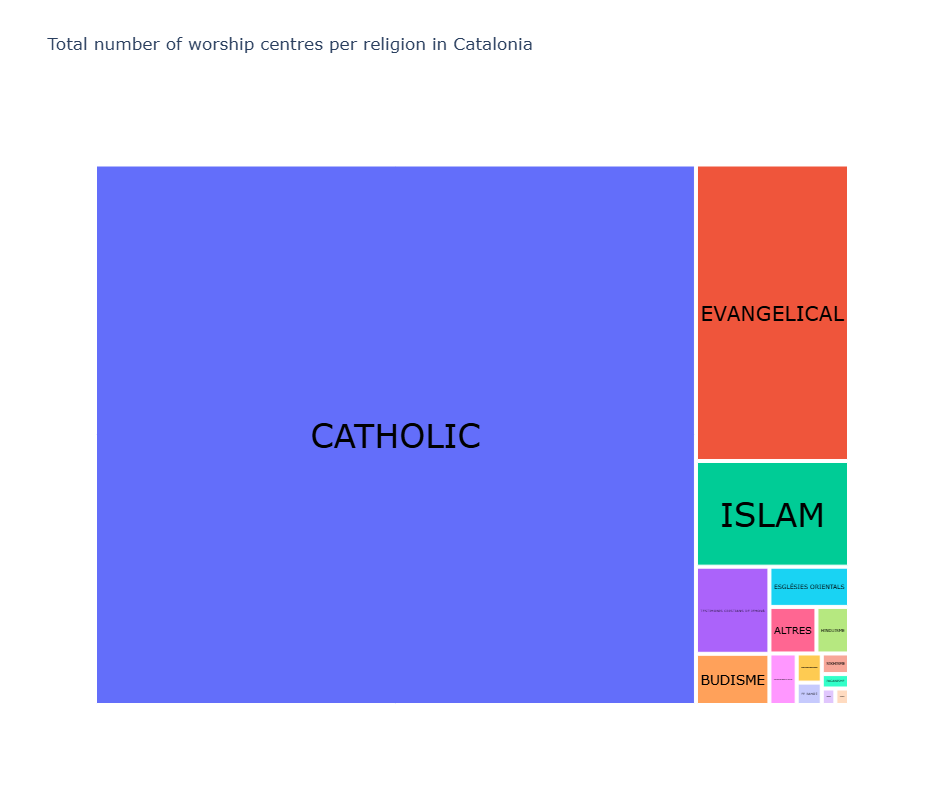

In [84]:
import pandas as pd
import plotly.express as px

# Asumiendo que `foreign_faith_distribution` es tu DataFrame original
# Sumar las columnas correspondientes
religions_columns = [
    'Sikhisme_2021', 'Judaisme_2021', 'Budisme_2021', 'Hinduisme_2021', 'Altres_2021',
    'Testimonis cristians de Jehovà_2021', 'Església Adventista del Setè Dia_2021',
    'Fe Bahà\'í_2021', 'Esglésies orientals_2021', 'Església de Jesucrist dels Sants dels Darrers Dies_2021',
    'Taoisme_2021', 'Paganisme_2021', 'Catholic_2021', 'Evangelical_2021', 'Islam_2021'
]

# Sumar los valores de todas las columnas para obtener el total por religión
total_religions = foreign_faith_distribution[religions_columns].sum()

# Crear un DataFrame con los resultados
df_total_religions = pd.DataFrame({
    'Religió': total_religions.index,
    'Centres': total_religions.values
})

# Eliminar el sufijo '_2021' y poner todo en mayúsculas para las etiquetas
df_total_religions['Religió'] = df_total_religions['Religió'].str.replace('_2021', '').str.upper()

# Crear el texto de las etiquetas manualmente (asegurarse de que el orden es correcto)
text_template = [
    "SIKHISM", "JUDAISM", "BUDISM", "HINDUISM", "DIVERSE FAITHS",
    "JEHOVAH'S WITNESSES", "ESGLÉSIA ADVENTISTA DEL SETÈ DIA",
    "FE BAHÀ'Í", "ORTHODOX", "ESGLÉSIA DE JESUCRIST DELS SANTS DELS DARRERS DIES",
    "TAOISM", "PAGANISM", "CATHOLIC", "EVANGELICAL", "ISLAM"  # Cambia estos valores si es necesario
]

# Asegúrate de que el número de etiquetas coincida con el número de categorías
if len(df_total_religions) == len(text_template):
    df_total_religions['Text'] = text_template
else:
    raise ValueError(f"El número de etiquetas no coincide con el número de religiones. ({len(df_total_religions)} vs {len(text_template)})")

# Crear el treemap
fig = px.treemap(df_total_religions, 
                 path=['Religió'], 
                 values='Centres',
                 title="Total number of worship centres per religion in Catalonia")

# Actualizar las trazas con el texto personalizado
fig.update_traces(
    textinfo="label",  # Solo mostrar la etiqueta, no el valor automáticamente
    textfont=dict(size=33, color='black'),  # Aumentar el tamaño de la fuente y color
    textposition='middle center',  # Centrar las etiquetas en los rectángulos
    text=df_total_religions['Text']  # Asignar las etiquetas personalizadas
)

# Ajustar el tamaño de la figura a un formato cuadrado
fig.update_layout(
    width=800,   # Ajusta el ancho
    height=800,  # Ajusta la altura
)

# Mostrar el gráfico
fig.show()
